In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PINN.utilities import V_BS

In [2]:
# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K  # truncted domain (0, inf]

np.random.seed(42)
torch.manual_seed(42);

In [3]:
#### European put option
N_i = 160
N_b = 40
N_pde = 2500
N_data = 0

# make data
# random sample S in (0, S_inf), tau in (0, 1)
# initial condition V(S, 0) = max(K - S, 0)
S_ib = torch.rand(N_i, 1)*S_inf
tau_ib = torch.zeros(N_i, 1)
V_ib = torch.max(K - S_ib, torch.zeros_like(S_ib))
# boundary condition V(0, tau) = K*exp(-r*tau), V(S_inf, tau) = 0
S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
tau_ib = torch.cat([tau_ib, torch.rand(2*N_b, 1)*T], dim=0)
V_ib = torch.cat([V_ib, K*torch.exp(-r*tau_ib[N_i:N_i+N_b]), torch.zeros((N_b, 1))], dim=0)
# PDE points
S_pde = torch.rand(N_pde, 1)*S_inf
tau_pde = torch.rand(N_pde, 1)

# require_grad = True
S_ib.requires_grad = True
tau_ib.requires_grad = True
V_ib.requires_grad = True
S_pde.requires_grad = True
tau_pde.requires_grad = True


# # save data
# torch.save({'S': S_ib, 'tau': tau_ib, 'V': V_ib}, './data/european_put_ib.pt')
# torch.save({'S': S_pde, 'tau': tau_pde}, './data/european_put_pde.pt')

In [5]:
N_pde = 2500

sobol = torch.quasirandom.SobolEngine(dimension=2)
sobol_samples = sobol.draw(N_pde).to(torch.float64)
S_pde = sobol_samples[:, 0].reshape(-1, 1)*S_inf
tau_pde = sobol_samples[:, 1].reshape(-1, 1)*T

In [76]:
# normal for S centred at K
S_pde = torch.normal(mean=K, std=K/4, size=(N_pde//4, 1))
# exp dist for S biased towards 0
S_pde = torch.concat([S_pde, torch.distributions.exponential.Exponential(2).sample((N_pde//4, 1))], dim=0)
S_pde = torch.clamp(S_pde, 0, S_inf)
# beta dist for tau biased towards 0
tau_pde = torch.distributions.beta.Beta(.5, .5).sample((N_pde//2, 1))*T
# # exponential dist for tau
# tau_pde = torch.distributions.exponential.Exponential(1/(T/4)).sample((N_pde//2, 1))*T
tau_pde = torch.clamp(tau_pde, 0, T)

# mix with sobol
sobol = torch.quasirandom.SobolEngine(dimension=2)
base_samples = sobol.draw(N_pde//2)
# # mix with uniform
# base_samples = torch.concat([torch.rand(N_pde//2, 1), torch.rand(N_pde//2, 1)], dim=1)


S_pde = torch.cat([S_pde, base_samples[:, 0].reshape(-1, 1)*S_inf], dim=0)
tau_pde = torch.cat([tau_pde, base_samples[:, 1].reshape(-1, 1)*T], dim=0)

Text(0, 0.5, 'S')

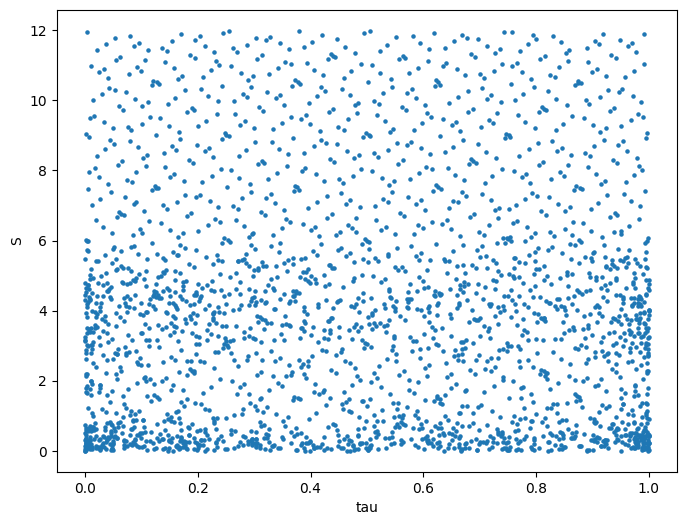

In [77]:
# # load data
# ib = torch.load('./data/european_put_ib.pt')
# pde = torch.load('./data/european_put_pde.pt')
# S_ib = ib['S']
# tau_ib = ib['tau']
# V_ib = ib['V']
# S_pde = pde['S']
# tau_pde = pde['tau']


# plot pde points
plt.figure(figsize=(8, 6))
plt.scatter(tau_pde.detach().numpy(), S_pde.detach().numpy(), s=5)
plt.xlabel('tau')
plt.ylabel('S')

In [ ]:
#### European call option
N_i = 160
N_b = 40
N_pde = 5000
N_data = 0
# make data
# random sample S in (0, S_inf), tau in (0, 1)
# initial condition V(S, 0) = max(S - K, 0)
S_ib = torch.rand(N_i, 1)*S_inf
tau_ib = torch.zeros(N_i, 1)
V_ib = torch.max(S_ib - K, torch.zeros_like(S_ib))
# boundary condition V(0, tau) = 0, V(S_inf, tau) = S_inf - K*exp(-r*tau)
S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
tau_ib = torch.cat([tau_ib, torch.rand(2*N_b, 1)*T], dim=0)
V_ib = torch.cat([V_ib, torch.zeros((N_b, 1)), torch.full((N_b, 1), S_inf)-K*torch.exp(-r*tau_ib[N_i:N_i+N_b])], dim=0)
# PDE points
S_pde = torch.rand(N_pde, 1)*S_inf
tau_pde = torch.rand(N_pde, 1)
#  data points
if N_data > 0:
    S_data = torch.rand(N_data, 1)*S_inf
    tau_data = torch.rand(N_data, 1)
    V_data = V_BS(S_data, tau_data, K, r, sigma, 'call')
    S_data.requires_grad = True
    tau_data.requires_grad = True
    V_data.requires_grad = True
else:
    S_data = None
    tau_data = None
    V_data = None

# require_grad = True
S_ib.requires_grad = True
tau_ib.requires_grad = True
V_ib.requires_grad = True
S_pde.requires_grad = True
tau_pde.requires_grad = True

# save data
torch.save({'S': S_ib, 'tau': tau_ib, 'V': V_ib}, './data/european_call_ib.pt')
torch.save({'S': S_pde, 'tau': tau_pde}, './data/european_call_pde.pt')
if N_data > 0:
    torch.save({'S': S_data, 'tau': tau_data, 'V': V_data}, './data/european_call_data.pt')